In [363]:
from datasets import load_dataset
import cv2
import albumentations
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.transforms import v2
from tqdm import tqdm

import os

In [364]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
ds = load_dataset("mrm8488/ImageNet1K-val", split="train")

ds

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['image', 'label'],
    num_rows: 1500
})

In [366]:
train_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(size=(142, 142)),
        v2.RandomCrop(size=(128, 128)),
        v2.RandomVerticalFlip(0.5),
        v2.RandomHorizontalFlip(0.5),
        v2.ColorJitter(0.25, 0.25, 0.25, 0.1),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

test_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(size=(128, 128)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

show_transforms = v2.Resize(size=(128, 128))


def train_transform(dataset):
    dataset["image"] = [train_transforms(image) for image in dataset["image"]]
    return dataset


def test_transform(dataset):
    dataset["image"] = [test_transforms(image) for image in dataset["image"]]
    return dataset


train_test = ds.train_test_split(test_size=0.1, seed=42)
train_val = train_test["train"].train_test_split(test_size=0.2, seed=42)

train_data = train_val["train"].with_transform(train_transform)
val_data = train_val["test"].with_transform(test_transform)
test_data = train_test["test"].with_transform(test_transform)

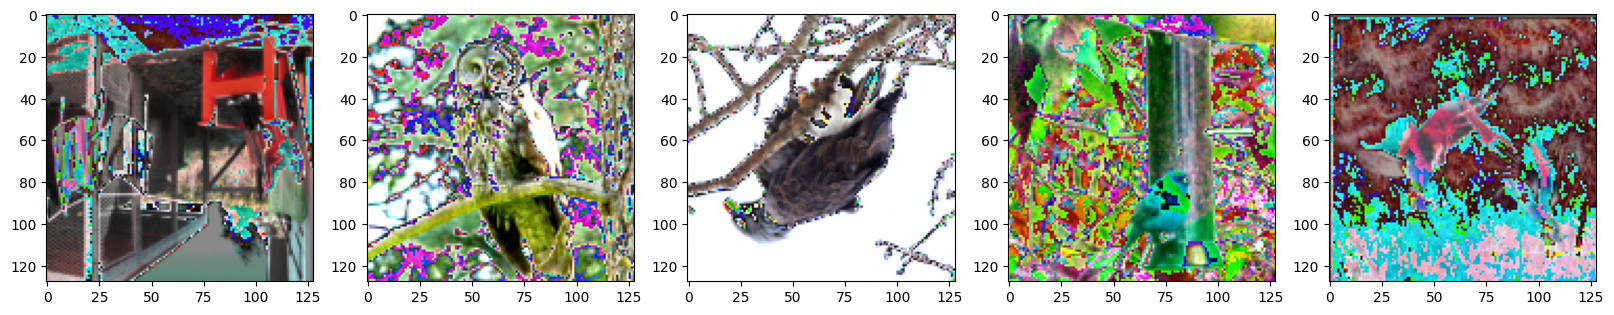

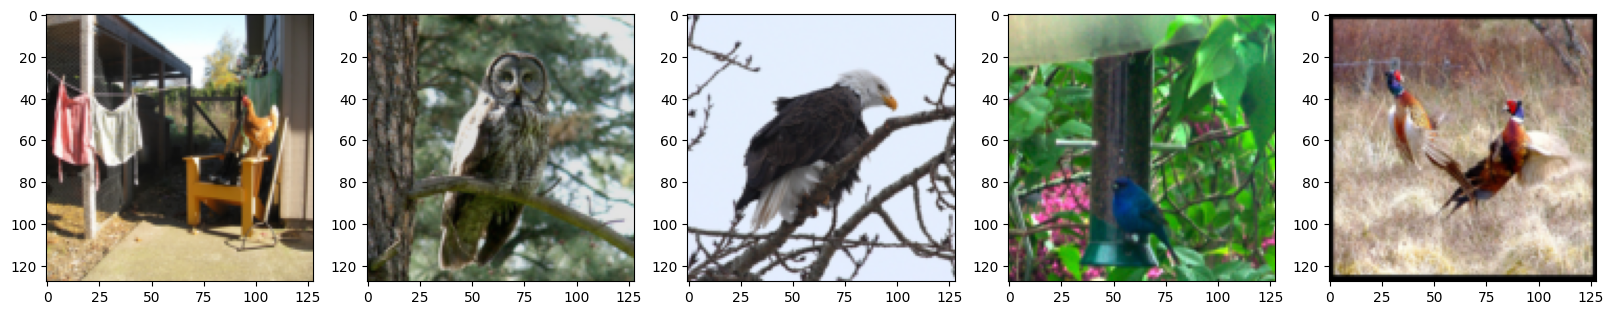

In [ ]:
def show_in_row(dataset, end: int, start: int = 0, trans: bool = True):
    plt.figure(figsize=(20, 6))
    for i in range(start, end):
        plt.subplot(1, (end - start), i + 1)
        if trans:
            plt.imshow((v2.ToPILImage()(dataset[i]["image"])))
        else:
            plt.imshow((dataset.with_transform(show_transforms)[i]["image"]))
    plt.show()


show_in_row(train_data, 5)
show_in_row(train_data, 5, trans=False)

In [368]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=1000):
        super(CNN, self).__init__()

        # Feature Extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1),  # 62x62x64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 30x30x64
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # 30x30x192
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 14x14x192
            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # 14x14x384
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # 14x14x256
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 14x14x256
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 6x6x256
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),  # FC1
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),  # FC2
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),  # FC3
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [370]:
cnn = CNN()
cnn.to(device)

optimizer = optim.Adam(cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [371]:
def calc_corrects(model, batch):
    labels, inputs = batch.values()
    labels = labels.to(device)
    inputs = inputs.to(device)
    logits = model(inputs)

    preds = F.softmax(logits, dim=1).argmax(dim=1)
    correct = (preds == labels).sum().item()

    return correct


def save_checkpoint(accuracy, model, optimizer, loss, filename="checkpoint.pth.tar"):
    if os.path.exists(filename):
        return
    state = {
        "accuracy": accuracy,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
    }
    torch.save(state, filename)
    print(f"Checkpoint saved to {filename}")

In [ ]:
num_epochs = 800

for epoch in range(num_epochs):
    cnn.train()
    running_loss = 0.0

    for data in tqdm(train_loader):
        images, labels = data.values()
        images, labels = images.to("cuda"), labels.to("cuda")

        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}"
    )

    cnn.eval()
    total, correct = 0, 0

    with torch.no_grad():
        for data in tqdm(val_loader):
            images, labels = data.values()
            images, labels = images.to("cuda"), labels.to("cuda")

            outputs = cnn(images)
            val_loss = criterion(outputs, labels)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

    if epoch % 50 == 0:
        torch.save(
            {
                "epoch": epoch,
                "model": cnn.state_dict(),
                "optimizer": optimizer.state_dict(),
                "loss": loss,
                "val_loss": val_loss,
                "accuracy": accuracy,
            },
            f"epoch_{epoch}.pth",
        )

        print(f"Epoch #{epoch} saved")

100%|██████████| 17/17 [00:05<00:00,  3.29it/s]


Epoch [1/800], Loss: 4.4985


100%|██████████| 5/5 [00:00<00:00,  6.63it/s]


Accuracy: 3.33%
Epoch #0 saved


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]


Epoch [2/800], Loss: 3.5458


100%|██████████| 5/5 [00:00<00:00,  6.63it/s]


Accuracy: 2.96%


100%|██████████| 17/17 [00:04<00:00,  3.43it/s]


Epoch [3/800], Loss: 3.4442


100%|██████████| 5/5 [00:00<00:00,  6.86it/s]


Accuracy: 3.70%


100%|██████████| 17/17 [00:05<00:00,  3.35it/s]


Epoch [4/800], Loss: 3.4332


100%|██████████| 5/5 [00:00<00:00,  6.69it/s]


Accuracy: 2.22%


 29%|██▉       | 5/17 [00:01<00:03,  3.01it/s]


KeyboardInterrupt: 